In [1]:
import json
import glob

val_files = "/plancraft/outputs/react_symb_ota-llama3.1-r16-a32_stp80/val.small.easy/0/*.json"
# val_files = "/plancraft/outputs/act_symb_ota-llama3.1-r16-a32_stp80/val.small.easy/0/*.json"

data = []
for ota_path in sorted(glob.glob(val_files)):
    with open(ota_path, "r") as f:
        ota_data = json.load(f)
    
    
    filename = ota_path.split("/")[-1]
    oa_path = f"/plancraft/outputs/act_symb_oa-llama3.1-r64-a32_stp80/val.small.easy/0/{filename}"

    with open(oa_path, "r") as f:
        oa_data = json.load(f)


    data.append((filename, ota_data["success"], oa_data["success"]))

    if not oa_data["success"]:
        continue
    if ota_data["success"]:        
        continue

    print(f"{filename} failed in OTA only")
    for h in ota_data["model_trace"]["dialogue_history"]:
        if h["content"] == "Ok":
            continue
        print(h)
    print()
    for h in oa_data["model_trace"]["dialogue_history"]:
        print(h)
    print()

VAL0003.json failed in OTA only
{'role': 'user', 'content': 'Craft an item of type: red_dye\ninventory=[{"type": "netherite_leggings", "slot": 11, "quantity": 1}, {"type": "soul_campfire", "slot": 17, "quantity": 21}, {"type": "red_stained_glass_pane", "slot": 19, "quantity": 20}, {"type": "skull_banner_pattern", "slot": 21, "quantity": 1}, {"type": "pink_tulip", "slot": 22, "quantity": 26}, {"type": "mossy_cobblestone_slab", "slot": 23, "quantity": 29}, {"type": "stone_bricks", "slot": 26, "quantity": 9}, {"type": "diamond_hoe", "slot": 27, "quantity": 1}, {"type": "podzol", "slot": 29, "quantity": 37}, {"type": "saddle", "slot": 30, "quantity": 1}, {"type": "magenta_dye", "slot": 31, "quantity": 32}, {"type": "netherite_axe", "slot": 32, "quantity": 1}, {"type": "cyan_bed", "slot": 34, "quantity": 1}, {"type": "white_glazed_terracotta", "slot": 35, "quantity": 30}, {"type": "bat_spawn_egg", "slot": 43, "quantity": 51}, {"type": "melon", "slot": 44, "quantity": 1}, {"type": "red_tulip

0.6597938144329897 0.5154639175257731


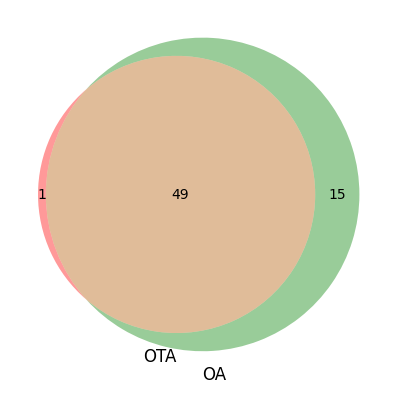

In [63]:
import pandas as pd

df = pd.DataFrame(data, columns=["filename", "ota_success", "oa_success"])
print(df["oa_success"].mean(), df["ota_success"].mean())
# venn diagram
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

ota_success = set(df[df["ota_success"]]["filename"])
oa_success = set(df[df["oa_success"]]["filename"])
venn2([ota_success, oa_success], ("OTA", "OA"))
plt.show()

In [20]:
inventory = [{"type": "dead_brain_coral_block", "slot": 11, "quantity": 29}, 
            {"type": "minecart", "slot": 15, "quantity": 1}, 
            {"type": "chainmail_helmet", "slot": 19, "quantity": 1}, 
            {"type": "tall_grass", "slot": 26, "quantity": 16}, 
            {"type": "tnt", "slot": 27, "quantity": 1}, 
            {"type": "warped_pressure_plate", "slot": 39, "quantity": 38}]

from plancraft.environments.recipes import RECIPES
r = RECIPES["tnt_minecart"][0]
print(r)
print(r.__prompt_repr__())


ShapedRecipe([[{167}], [{663}]], RecipeResult(item='tnt_minecart', count=1))
tnt
minecart -> 1 tnt_minecart


In [46]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model
import torch
model_name = 'xiaodongguaAIGC/llama-3-debug'
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [47]:
target_modules = [
            "q_proj",
            "v_proj",
            "k_proj",
        ]

lora_config = LoraConfig(
    r=64,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=target_modules,
    init_lora_weights="gaussian",
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config, adapter_name="act")
model.add_adapter(adapter_name="think", peft_config=lora_config)
model.print_trainable_parameters()

trainable params: 24,576 || all params: 16,507,072 || trainable%: 0.1489


In [4]:
model.set_adapter("think")
model.set_adapter("act")


In [48]:
model.set_adapter("think")
# push to hub only the adapter
model.save_pretrained("tmp")
# model.push_to_hub("gautierdag/small-adapter-test", use_temp_dir=True, repo_name="gautierdag/small-adapter-test", commit_message="think adapter", token="hf_")

In [58]:
model = AutoModelForCausalLM.from_pretrained("tmp/act")
# model = model.load_adapter("tmp/act", "plancraft")

Loading images


In [87]:
len(dataset)

5368

In [2]:
# for i in range(100):
    # print(i, collate_fn([dataset[i]])["input_ids"].shape[1])
from transformers import AutoTokenizer

batch = collate_fn([dataset[493]])

tokenizer = AutoTokenizer.from_pretrained("/nfs/public/hf/models/meta-llama/Meta-Llama-3.1-8B-Instruct")

print(tokenizer.decode(batch["input_ids"][0]))


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are crafting in Minecraft. You need to decide on the next action.

You must output an action like the following:
act: move from slot X to slot Y with quantity Z

There are two types of actions
- move
- smelt

To assist with planning, you first generate some thoughts before answering. 

The first 10 slots in the inventory are reserved for crafting and correspond to the minecraft crafting table. 

[1, 2, 3] 
[4, 5, 6] -> [0]
[7, 8, 9]

The crafting matrix is a 3x3 grid, and the output is sent to slot 0.
You cannot move or smelt items into output slot 0.
The remaining slots (10-45) are for storing items.<|eot_id|><|start_header_id|>user<|end_header_id|>

Craft an item of type: smooth_quartz
inventory=[{"type": "polished_blackstone_stairs", "quantity": 7, "index": 10}, {"type": "prismarine_bricks", "quantity": 25, "index": 11}, {"type": "ravager_spawn_egg", "quant

In [3]:
print(tokenizer.decode(batch["input_ids"][batch["labels"] != -100]))

thought: To craft a quartz_block, I need to place 4 quartz in a square in the crafting grid. There are currently 4 quartz in slot 33, so I will move one to slot 1.<|eot_id|>act: move from slot 33 to slot 1 with quantity 1<|eot_id|>thought: I need to place 3 more quartz in the crafting grid to complete the square. I will move one to slot 2.<|eot_id|>act: move from slot 33 to slot 2 with quantity 1<|eot_id|>thought: I will move one quartz to slot 4.<|eot_id|>act: move from slot 33 to slot 4 with quantity 1<|eot_id|>thought: I will move one quartz to slot 5.<|eot_id|>act: move from slot 33 to slot 5 with quantity 1<|eot_id|>thought: The quartz_block has been crafted. I will move it to a free inventory slot (eg., 12).<|eot_id|>act: move from slot 0 to slot 12 with quantity 1<|eot_id|>thought: To craft a smooth_quartz, I need to smelt a quartz_block. The only quartz_block in my inventory is in slot 12, so I will smelt it into an empty slot (eg., 13).<|eot_id|>act: smelt from slot 12 to slot